Script to plot maps of annual mean precipitation on SAFRAN moving sub-domains

In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from config import *
from functions import *
from utils import *

In [6]:
### CST ###

reg = 'Fr'
dataset = 'SAFRAN'
ymin = 1976
ymax = 1976
years = np.arange(ymin, ymax+1, 1)
per = str(ymin) + '-' + str(ymax)
sizes = [40, 50, 60]  # 10, 20, 30,    # domain side length (number of pixels)
prop = 0.1  # proportion du côté de la fenêtre sans recouvrement (dans les deux directions)
th_n = 0.75  # minimum proportion of land grid cell for the sub-domain to be considered

projmap = ccrs.LambertConformal(central_longitude=2.337229, central_latitude=46.8, false_easting=600000., false_northing=2200000.)
resol = '50m'  # use data at this scale
bodr = cfeature.NaturalEarthFeature(category='cultural', 
    name='admin_0_boundary_lines_land', scale=resol, facecolor='none', alpha=0.7)

In [3]:
#~ OUTDIR

if not os.path.isdir(FIGDIR + '/for_article'):
    os.mkdir(FIGDIR + '/for_article')
figdir = FIGDIR + '/for_article'

In [4]:
# Get France polygon and reprojectin SAFRAN CRS
cnydbffile = SHAPEDIR + '/world-boundaries/world-administrative-boundaries.dbf'
dfcny = gpd.read_file(cnydbffile)
dffra = gpd.GeoSeries(dfcny.iloc[93]['geometry'])
dffra.set_crs(dfcny.crs, inplace=True)
dffra_reproj = dffra.to_crs(proj)

In [5]:
ds1 = get_data_yr_SAFR(1975)
ds2 = get_data_yr_SAFR(1976)
ds = xr.concat([ds1, ds2], dim='time')

ygps = ds.groupby('time.year').groups
ygp = ygps[1976]
ds_ = ds.isel(time=slice(ygp[0], ygp[-1]))


>>> 320x320 <<<


KeyboardInterrupt: 

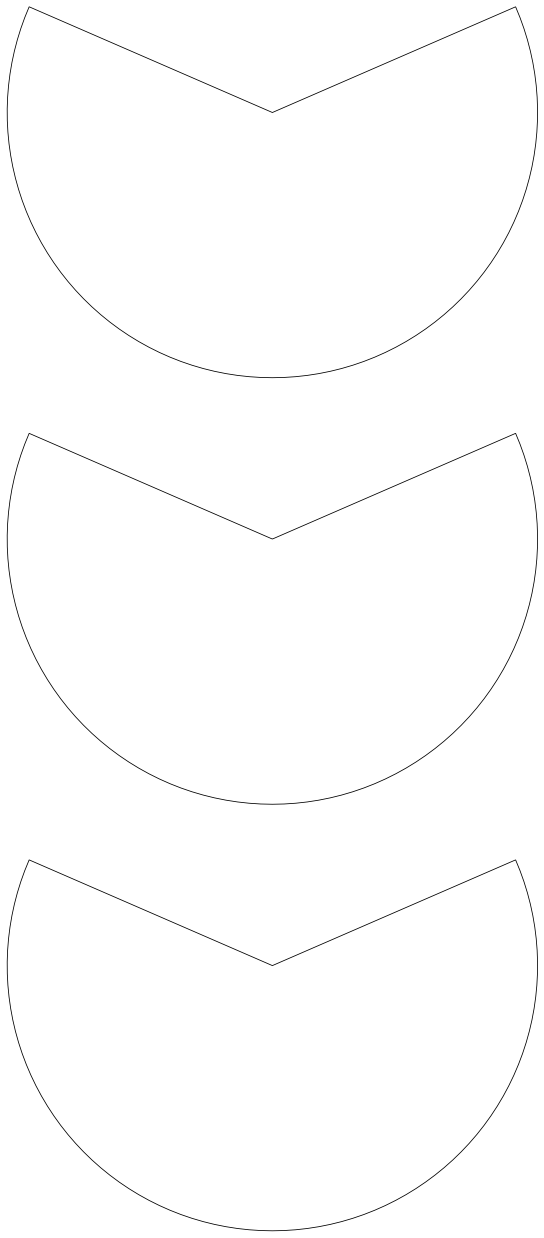

In [23]:
# plot maps of annual mean precip.
cmap_map = 'viridis_r'
cmap_map = plt.cm.get_cmap(cmap_map)

#ncols_map = np.arange(0, 1400+200, 200)  # int(np.nanmax(cum))
ncols_map = [0., 400., 600., 800., 1000., 1200., 1400., 1600., 2000.]
norm_map = BoundaryNorm(ncols_map, ncolors=cmap_map.N, clip=True)

xlims = (50000., 1200000.)
ylims = (1600000., 2750000.)
xtcks = np.linspace(xlims[0], xlims[1], 6)
ytcks = np.linspace(ylims[0], ylims[1], 6)
xtlbs = [int(xt/1000) for xt in xtcks]
ytlbs = [int(yt/1000) for yt in ytcks]


fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20., 20.), subplot_kw={'projection': projmap})

plt.subplots_adjust(bottom=0.1, top=0.95, wspace=0.15, hspace=0.15)

i=0
j=0

for isize, size in enumerate(sizes):
    size_ = str(int(size*res/1000)) + 'x' + str(int(size*res/1000))
    print('\n>>> {0} <<<'.format(size_))

    step = int(round(size * prop, 0))  # décalage dans la sélection des coordonnées des sous-fenêtres
    ntot = size **2  # total number of pixel within domain

    #~ Get valid cells to compute matrices of precip. acc. and NEPs -> ALREADY DONE (METHOD 1)
    # Min and max coordinates (x, y) of the lower left pixel of sub-domains
    x_min_ = x_min
    x_max_ = x_max - size * res
    x_min_, x_max_
    y_min_ = y_min
    y_max_ = y_max - size * res
    (x_min_, y_min_), (x_max_, y_max_)

    # Coordinates of the lower left pixel of all sub-domains
    xs = pd.Series(np.arange(x_min_, x_max_+res, res))  # all x coordinates
    ys = pd.Series(np.arange(y_min_, y_max_+res, res))  # all y coordinates

    # Sub-sample sub-domains coordinates (-> over-lapping)
    xs_ = xs[::step]
    ys_ = ys[::step]

    # Get all subdomains lower left (ll) coordinates (x, y)
    #ll_cells = []
    cums = []
    for x0 in xs_:
        cums_ = []
        for y0 in ys_:
            x1 = x0 + size * res - res
            y1 = y0 + size * res - res

            data = ds_.sel(x=slice(x0, x1), y=slice(y0, y1)).mean(dim='time').product.values

            if len(data[~np.isnan(data)]) >= ntot*th_n:
                #valid_cells.append((xs, ys))
                #print(ll_cell, end=' : ', flush=True)
                cum = data * 3600 * len(ds_.time) / len(years)
                cums_.append(cum)
            else:
                cums_.append(np.nan)

        cums.append(cums_)

    '''icell = np.random.randint(0, high=len(valid_cells), size=1)[0]
    cell = valid_cells[icell]
    coord = (cell[0][0], cell[1][0])  # xmin, ymin

    data = ds_.sel(x=slice(cell[0][0], cell[0][1]), y=slice(cell[1][0], cell[1][1]))'''

    cums = np.asarray(cums)
    da = xr.DataArray(data=cums, dims=ds_.dims, coords=ds_.coords)

    print(i, j, end=' : ', flush=True)
    if j==ax.shape[1]:
        j=0
        i=i+1
        
    ax_ = ax[i][j]
    #ax_ = ax[i//3, i % 3]

    p = ax_.pcolor(cum.indexes['x'], cum.indexes['y'], cum, norm=norm_map, cmap=cmap_map)
    ax_.text(0.025, 0.05, '{0} mm'.format(int(cum.mean().values.round(0))), transform=ax_.transAxes)

    #ax_.scatter(x_center, y_center, s=10, c='r', marker='x', zorder=100)

    dffra_reproj.boundary.plot(ax=ax_, color='k')

    ax_.set_xticks(xtcks)
    ax_.set_yticks(ytcks)
    ax_.tick_params(axis='x', direction='in')
    ax_.tick_params(axis='y', direction='in')

    if j == 0:
        ax_.set_yticklabels(ytlbs, rotation=45)
        ax_.set_ylabel('LII Y [km]')
    else:
        ax_.set_yticklabels([])
    if i == ax.shape[0]-1:
        ax_.set_xticklabels(xtlbs, rotation=45)
        ax_.set_xlabel('LII X [km]')
    else:
        ax_.set_xticklabels([])

    ax_.set_xlim(xlims)
    ax_.set_ylim(ylims)

    #ax_.add_feature(bodr, linestyle='--', edgecolor='k', alpha=1)  -> add feature on subplots ???
    #ax_.coastlines()  -> pb with shapely ??? (pip3 install shapely==1.8.2 -> change to former version?)
    ax_.set_title(size_)
    j=j+1


fig.colorbar(p, ax=ax[:ax.shape[0]], orientation='horizontal', label='Annual precip. [mm]', shrink=0.5, pad=0.1)
    

# Save

figfile = figdir + '/fig3.png'
fig.savefig(figfile, dpi=300)